In [72]:
# Applying logistic regression in python to discriminate between control and M. bovis infected animals using peripheral blood transcriptomics data from kirsten et al., 2021
### This analysis considers two approaches, one using logistic regression on variable genes that have been preprocessed using DESeq2 (vst normalised) and the other using latent variables inferred using PCA, ICA and NMF
## Load in all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from scipy import stats
from scipy.stats import kurtosis

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,roc_curve,auc, make_scorer,mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, PredefinedSplit
from sklearn.decomposition import PCA, NMF, FastICA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
import warnings
import pickle
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

#font for plots
font = {'fontname':'Arial'}

In [73]:
# Read in all labels for data sets
# Abdelaal
abdelaal_labels = pd.read_csv("/home/workspace/jogrady/ML4TB/data/abdelaal/abdelaal_samples.csv", sep = "\t")
abdelaal_labels = abdelaal_labels[["Animal_Code", "Week", "Status"]].drop_duplicates()
abdelaal_labels = np.array(abdelaal_labels["Status"])
abdelaal_labels = np.where(abdelaal_labels == "Control", 0, np.where(abdelaal_labels == "Infected", 1, abdelaal_labels))
abdelaal_labels_simple = abdelaal_labels.astype(int)

# Wiarda
wiarda_labels = pd.read_csv("/home/workspace/jogrady/ML4TB/data/wiarda/wiarda_samples.csv", sep = "\t")
wiarda_labels = wiarda_labels[["Animal_Code", "Week", "Status"]].drop_duplicates()

wiarda_labels["ID"] = wiarda_labels["Animal_Code"].str.extract(r"(\d{3})", expand=False)
wiarda_labels["Fold"] = wiarda_labels.groupby("ID").ngroup()
wiarda_labels.loc[wiarda_labels["Week"] == "W0", "Status"] = "Control" # Note the infected samples were sampled after infection (immediately) so may be worthwhile labelling them as Control (note this increased the CV accuracy from ~ 50 to 80)


wiarda_labels_simple = wiarda_labels["Status"].to_numpy()
wiarda_folds = wiarda_labels["Fold"].to_numpy()


wiarda_labels_simple = np.where(wiarda_labels_simple == "Control", 0, np.where(wiarda_labels_simple == "Infected", 1, wiarda_labels_simple))
wiarda_labels_simple = wiarda_labels_simple.astype(int)


# Kirsten_pbl
kirsten_pbl_labels = pd.read_csv("/home/workspace/jogrady/ML4TB/data/kirsten_pbl/kirsten_pbl_samples.csv", sep = "\t")

kirsten_pbl_labels
kirsten_pbl_labels["Fold"] = kirsten_pbl_labels.groupby("Run_Code").ngroup()


kirsten_pbl_labels_simple = kirsten_pbl_labels["Status"].to_numpy()
kirsten_pbl_folds = kirsten_pbl_labels["Fold"].to_numpy()


kirsten_pbl_labels_simple = np.where(kirsten_pbl_labels_simple == "Control", 0, np.where(kirsten_pbl_labels_simple == "Infected", 1, kirsten_pbl_labels_simple))
kirsten_pbl_labels_simple = kirsten_pbl_labels_simple.astype(int)


# Kirsten

kirsten_labels = pd.read_csv("/home/workspace/jogrady/ML4TB/data/kirsten/kirsten_samples.csv", sep = "\t")
kirsten_labels = kirsten_labels[["Animal_Code", "Week", "Status"]].drop_duplicates()
kirsten_labels["ID"] = kirsten_labels["Animal_Code"].str.extract(r"(A\d{4})", expand=False)
kirsten_labels["Fold"] = kirsten_labels.groupby("ID").ngroup()

kirsten_labels_simple = kirsten_labels["Status"].to_numpy()
kirsten_folds = kirsten_labels["Fold"].to_numpy()


kirsten_labels_simple = np.where(kirsten_labels_simple == "Control", 0, np.where(kirsten_labels_simple == "Infected", 1, kirsten_labels_simple))
kirsten_labels_simple = kirsten_labels_simple.astype(int)


# O'Grady train
abdelaallabels = np.array(pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_individual/Train_labels.txt", sep = "\t").T) 
abdelaallabels = np.where(abdelaallabels == "Control", 0, np.where(abdelaallabels == "Infected", 1, abdelaallabels))
abdelaallabels_simple = abdelaallabels.astype(int).ravel()

# 1. O'Grady model

### Read in model, data and labels

In [74]:
ensemble = pd.read_csv(
    "/home/workspace/jogrady/eqtl_study/eqtl_nextflow/data/RNA_seq/Bos_taurus.ARS-UCD1.2.110.gtf",
    sep="\t",
    header=None,
    comment="#",
)
# Filter for rows where column 3 (V3) is "gene"
ensemble = ensemble[ensemble[2] == "gene"]

# Split column 9 (V9) into separate columns for gene_id, gene_version, and gene_name
ensemble_split = ensemble[8].str.split(";", expand=True)
ensemble["gene_id"] = ensemble_split[0].str.replace("^gene_id ", "", regex=True).str.replace('"', '', regex=False)
ensemble["gene_version"] = ensemble_split[1]
ensemble["gene_name"] = ensemble_split[2].str.replace("gene_name ", "", regex=True).str.replace('"', '', regex=False)

# Clean up the gene_name column
ensemble["gene_name"] = (
    ensemble["gene_name"]
    .str.replace("gene_source ", "", regex=False)
    .str.strip()
)
ensemble["gene_name"] = np.where(
    ensemble["gene_name"].isin(["ensembl", "5S_rRNA"]), 
    ensemble["gene_id"], 
    ensemble["gene_name"]
)

# Rename columns
ensemble.rename(columns={0: "chr"}, inplace=True)
ensemble = ensemble[["gene_id", "gene_name", "chr", 3]]
ensemble.rename(columns={3: "pos"}, inplace=True)

# Select only gene_id and gene_name
ensemble = ensemble[["gene_id", "gene_name"]]

# Handle duplicated gene_name values
ensemble["gene_name"] = np.where(
    ensemble["gene_name"].duplicated(), 
    ensemble["gene_id"], 
    ensemble["gene_name"]
)

# Clean up gene_id and gene_name columns for alignment
ensemble["gene_name"] = ensemble["gene_name"].str.replace(' ', '', regex=False)
ensemble["gene_id"] = ensemble["gene_id"].str.replace(' ', '', regex=False)

In [75]:
# Abdelaal
abdelaal_labels = pd.read_csv("/home/workspace/jogrady/ML4TB/data/abdelaal/abdelaal_samples.csv", sep = "\t")
abdelaal_labels = abdelaal_labels[["Animal_Code", "Week", "Status"]].drop_duplicates()
abdelaal_labels = np.array(abdelaal_labels["Status"])
abdelaal_labels = np.where(abdelaal_labels == "Control", 0, np.where(abdelaal_labels == "Infected", 1, abdelaal_labels))
abdelaal_labels_simple = abdelaal_labels.astype(int)

# Wiarda
wiarda_labels = pd.read_csv("/home/workspace/jogrady/ML4TB/data/wiarda/wiarda_samples.csv", sep = "\t")
wiarda_labels = wiarda_labels[["Animal_Code", "Week", "Status"]].drop_duplicates()

wiarda_labels["ID"] = wiarda_labels["Animal_Code"].str.extract(r"(\d{3})", expand=False)
wiarda_labels["Fold"] = wiarda_labels.groupby("ID").ngroup()
wiarda_labels.loc[wiarda_labels["Week"] == "W0", "Status"] = "Control" # Note the infected samples were sampled after infection (immediately) so may be worthwhile labelling them as Control (note this increased the CV accuracy from ~ 50 to 80)


wiarda_labels_simple = wiarda_labels["Status"].to_numpy()
wiarda_folds = wiarda_labels["Fold"].to_numpy()


wiarda_labels_simple = np.where(wiarda_labels_simple == "Control", 0, np.where(wiarda_labels_simple == "Infected", 1, wiarda_labels_simple))
wiarda_labels_simple = wiarda_labels_simple.astype(int)


# Kirsten_pbl
kirsten_pbl_labels = pd.read_csv("/home/workspace/jogrady/ML4TB/data/kirsten_pbl/kirsten_pbl_samples.csv", sep = "\t")

kirsten_pbl_labels
kirsten_pbl_labels["Fold"] = kirsten_pbl_labels.groupby("Run_Code").ngroup()


kirsten_pbl_labels_simple = kirsten_pbl_labels["Status"].to_numpy()
kirsten_pbl_folds = kirsten_pbl_labels["Fold"].to_numpy()


kirsten_pbl_labels_simple = np.where(kirsten_pbl_labels_simple == "Control", 0, np.where(kirsten_pbl_labels_simple == "Infected", 1, kirsten_pbl_labels_simple))
kirsten_pbl_labels_simple = kirsten_pbl_labels_simple.astype(int)


# Kirsten

kirsten_labels = pd.read_csv("/home/workspace/jogrady/ML4TB/data/kirsten/kirsten_samples.csv", sep = "\t")
kirsten_labels = kirsten_labels[["Animal_Code", "Week", "Status"]].drop_duplicates()
kirsten_labels["ID"] = kirsten_labels["Animal_Code"].str.extract(r"(A\d{4})", expand=False)
kirsten_labels["Fold"] = kirsten_labels.groupby("ID").ngroup()

kirsten_labels_simple = kirsten_labels["Status"].to_numpy()
kirsten_folds = kirsten_labels["Fold"].to_numpy()


kirsten_labels_simple = np.where(kirsten_labels_simple == "Control", 0, np.where(kirsten_labels_simple == "Infected", 1, kirsten_labels_simple))
kirsten_labels_simple = kirsten_labels_simple.astype(int)


# O'Grady train
ogrady_labels = np.array(pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_individual/Train_labels.txt", sep = "\t").T) 
ogrady_labels = np.where(ogrady_labels == "Control", 0, np.where(ogrady_labels == "Infected", 1, ogrady_labels))
ogrady_labels_simple = ogrady_labels.astype(int).ravel()



# O'Grady test
ogradytest_labels = np.array(pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_individual/Test_labels.txt", sep = "\t").T) 
ogradytest_labels = np.where(ogradytest_labels == "Control", 0, np.where(ogradytest_labels == "Infected", 1, ogradytest_labels))
ogradytest_labels_simple = ogradytest_labels.astype(int).ravel()

In [76]:
ogradytest_labels_simple

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [77]:

with open("/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/OGrady_Logistic_regression_l10.7_search.pkl", 'rb') as f:
    ogrady_gene = pickle.load(f)



with open("/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/OGrady_Logistic_regression_PCA_search.pkl", 'rb') as f:
    ogrady_pca = pickle.load(f)




with open("/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/OGrady_Logistic_regression_ICA_search.pkl", 'rb') as f:
    ogrady_ica = pickle.load(f)



with open("/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/OGrady_Logistic_regression_NMF_search.pkl", 'rb') as f:
    ogrady_nmf = pickle.load(f)
    
# Note the raw will be for if individuals wish to put in a MAD filter on the data
ogrady_train_data = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_individual/OGrady_train_vst_normalised_data.txt", sep = "\t").T


In [78]:
# The data and labels
ogrady_abdelaal = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_combined/abdelaal_ogrady_vst_normalised_data.txt", sep = "\t")
ogrady_wiarda = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_combined/wiarda_ogrady_vst_normalised_data.txt", sep = "\t")
ogrady_kirsten = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_combined/kirsten_ogrady_vst_normalised_data.txt", sep = "\t")
ogrady_kirsten_pbl = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_combined/kirsten_pbl_ogrady_vst_normalised_data.txt", sep = "\t")
ogrady_abdelaal.set_index(ogrady_train_data.T.index, inplace = True) 
ogrady_wiarda.set_index(ogrady_train_data.T.index,inplace = True) 
ogrady_kirsten.set_index(ogrady_train_data.T.index,inplace = True) 
ogrady_kirsten_pbl.set_index(ogrady_train_data.T.index,inplace = True)



# Calcualte variances for VST normalised genes
variances = ogrady_train_data.var(axis=0)
# take top 20% and filter
threshold = variances.quantile(.80) 
genes = variances > threshold
genes= genes.loc[genes==True].index
ogrady_train_data = ogrady_train_data.filter(items = genes, axis=1)


ogrady_abdelaal = ogrady_abdelaal.T.filter(items = genes, axis=1)

ogrady_wiarda = ogrady_wiarda.T.filter(items = genes, axis=1)

ogrady_kirsten = ogrady_kirsten.T.filter(items = genes, axis=1)

ogrady_kirsten_pbl = ogrady_kirsten_pbl.T.filter(items = genes, axis=1)






In [79]:
# Gene
y_score_gene = ogrady_gene.predict_proba(ogrady_abdelaal)
ogrady_abdelaal_fprG_gene, ogrady_abdelaal_tprG_gene, ogrady_abdelaal_t_gene = roc_curve(abdelaal_labels_simple, y_score_gene[:,1])
ogrady_abdelaal_roc_aucG_gene = auc(ogrady_abdelaal_fprG_gene, ogrady_abdelaal_tprG_gene)


y_score_gene = ogrady_gene.predict_proba(ogrady_wiarda)
ogrady_wiarda_fprG_gene, ogrady_wiarda_tprG_gene, ogrady_wiarda_t_gene = roc_curve(wiarda_labels_simple, y_score_gene[:,1])
ogrady_wiarda_roc_aucG_gene = auc(ogrady_wiarda_fprG_gene, ogrady_wiarda_tprG_gene)


y_score_gene = ogrady_gene.predict_proba(ogrady_kirsten)
ogrady_kirsten_fprG_gene, ogrady_kirsten_tprG_gene, ogrady_kirsten_t_gene = roc_curve(kirsten_labels_simple, y_score_gene[:,1])
ogrady_kirsten_roc_aucG_gene = auc(ogrady_kirsten_fprG_gene, ogrady_kirsten_tprG_gene)


y_score_gene = ogrady_gene.predict_proba(ogrady_kirsten_pbl)
ogrady_kirsten_pbl_fprG_gene, ogrady_kirsten_pbl_tprG_gene, ogrady_kirsten_pbl_t_gene = roc_curve(kirsten_pbl_labels_simple, y_score_gene[:,1])
ogrady_kirsten_pbl_roc_aucG_gene = auc(ogrady_kirsten_pbl_fprG_gene, ogrady_kirsten_pbl_tprG_gene)


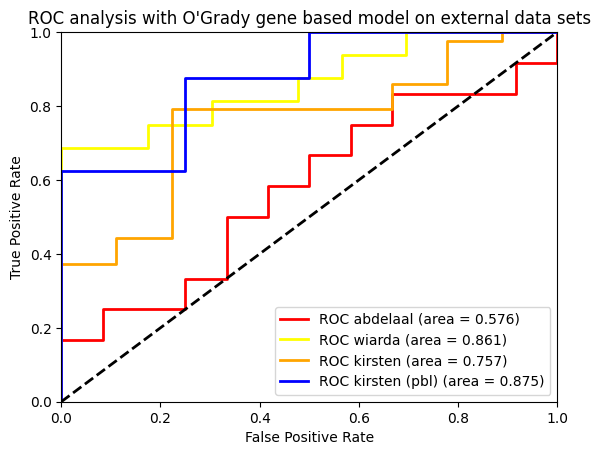

In [80]:
%matplotlib inline
plt.figure()
lw = 2
plt.plot(ogrady_abdelaal_fprG_gene, ogrady_abdelaal_tprG_gene, color='red',
         lw=lw, label='ROC abdelaal (area = %0.3f)' % ogrady_abdelaal_roc_aucG_gene)
plt.plot(ogrady_wiarda_fprG_gene, ogrady_wiarda_tprG_gene, color='yellow',
         lw=lw, label='ROC wiarda (area = %0.3f)' % ogrady_wiarda_roc_aucG_gene)
plt.plot(ogrady_kirsten_fprG_gene, ogrady_kirsten_tprG_gene, color='orange',
         lw=lw, label='ROC kirsten (area = %0.3f)' % ogrady_kirsten_roc_aucG_gene)
plt.plot(ogrady_kirsten_pbl_fprG_gene, ogrady_kirsten_pbl_tprG_gene, color='blue',
         lw=lw, label='ROC kirsten (pbl) (area = %0.3f)' % ogrady_kirsten_pbl_roc_aucG_gene)

plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC analysis with O'Grady gene based model on external data sets")
plt.legend(loc="lower right")
plt.show()

In [81]:
y_score_pca = ogrady_pca.predict_proba(ogrady_abdelaal)
ogrady_abdelaal_fprG_pca, ogrady_abdelaal_tprG_pca, ogrady_abdelaal_t_pca = roc_curve(abdelaal_labels_simple, y_score_pca[:,1])
ogrady_abdelaal_roc_aucG_pca = auc(ogrady_abdelaal_fprG_pca, ogrady_abdelaal_tprG_pca)


y_score_pca = ogrady_pca.predict_proba(ogrady_wiarda)
ogrady_wiarda_fprG_pca, ogrady_wiarda_tprG_pca, ogrady_wiarda_t_pca = roc_curve(wiarda_labels_simple, y_score_pca[:,1])
ogrady_wiarda_roc_aucG_pca = auc(ogrady_wiarda_fprG_pca, ogrady_wiarda_tprG_pca)


y_score_pca = ogrady_pca.predict_proba(ogrady_kirsten)
ogrady_kirsten_fprG_pca, ogrady_kirsten_tprG_pca, ogrady_kirsten_t_pca = roc_curve(kirsten_labels_simple, y_score_pca[:,1])
ogrady_kirsten_roc_aucG_pca = auc(ogrady_kirsten_fprG_pca, ogrady_kirsten_tprG_pca)


y_score_pca = ogrady_pca.predict_proba(ogrady_kirsten_pbl)
ogrady_kirsten_pbl_fprG_pca, ogrady_kirsten_pbl_tprG_pca, ogrady_kirsten_pbl_t_pca = roc_curve(kirsten_pbl_labels_simple, y_score_pca[:,1])
ogrady_kirsten_pbl_roc_aucG_pca = auc(ogrady_kirsten_pbl_fprG_pca, ogrady_kirsten_pbl_tprG_pca)

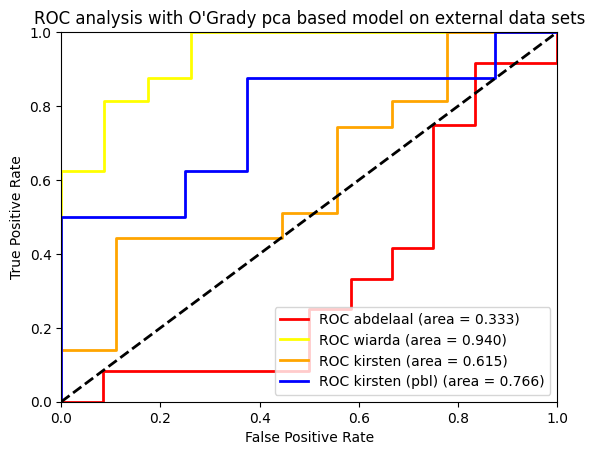

In [82]:
%matplotlib inline
plt.figure()
lw = 2
plt.plot(ogrady_abdelaal_fprG_pca, ogrady_abdelaal_tprG_pca, color='red',
         lw=lw, label='ROC abdelaal (area = %0.3f)' % ogrady_abdelaal_roc_aucG_pca)
plt.plot(ogrady_wiarda_fprG_pca, ogrady_wiarda_tprG_pca, color='yellow',
         lw=lw, label='ROC wiarda (area = %0.3f)' % ogrady_wiarda_roc_aucG_pca)
plt.plot(ogrady_kirsten_fprG_pca, ogrady_kirsten_tprG_pca, color='orange',
         lw=lw, label='ROC kirsten (area = %0.3f)' % ogrady_kirsten_roc_aucG_pca)
plt.plot(ogrady_kirsten_pbl_fprG_pca, ogrady_kirsten_pbl_tprG_pca, color='blue',
         lw=lw, label='ROC kirsten (pbl) (area = %0.3f)' % ogrady_kirsten_pbl_roc_aucG_pca)

plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC analysis with O'Grady pca based model on external data sets")
plt.legend(loc="lower right")
plt.show()

In [83]:
y_score_ica = ogrady_ica.predict_proba(ogrady_abdelaal)
ogrady_abdelaal_fprG_ica, ogrady_abdelaal_tprG_ica, ogrady_abdelaal_t_ica = roc_curve(abdelaal_labels_simple, y_score_ica[:,1])
ogrady_abdelaal_roc_aucG_ica = auc(ogrady_abdelaal_fprG_ica, ogrady_abdelaal_tprG_ica)


y_score_ica = ogrady_ica.predict_proba(ogrady_wiarda)
ogrady_wiarda_fprG_ica, ogrady_wiarda_tprG_ica, ogrady_wiarda_t_ica = roc_curve(wiarda_labels_simple, y_score_ica[:,1])
ogrady_wiarda_roc_aucG_ica = auc(ogrady_wiarda_fprG_ica, ogrady_wiarda_tprG_ica)


y_score_ica = ogrady_ica.predict_proba(ogrady_kirsten)
ogrady_kirsten_fprG_ica, ogrady_kirsten_tprG_ica, ogrady_kirsten_t_ica = roc_curve(kirsten_labels_simple, y_score_ica[:,1])
ogrady_kirsten_roc_aucG_ica = auc(ogrady_kirsten_fprG_ica, ogrady_kirsten_tprG_ica)


y_score_ica = ogrady_ica.predict_proba(ogrady_kirsten_pbl)
ogrady_kirsten_pbl_fprG_ica, ogrady_kirsten_pbl_tprG_ica, ogrady_kirsten_pbl_t_ica = roc_curve(kirsten_pbl_labels_simple, y_score_ica[:,1])
ogrady_kirsten_pbl_roc_aucG_ica = auc(ogrady_kirsten_pbl_fprG_ica, ogrady_kirsten_pbl_tprG_ica)

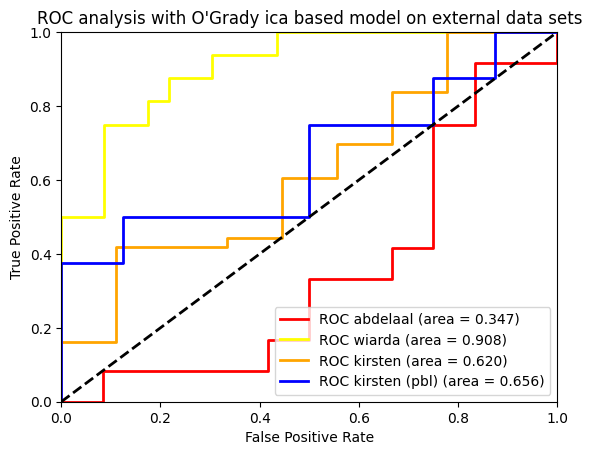

In [84]:
%matplotlib inline
plt.figure()
lw = 2
plt.plot(ogrady_abdelaal_fprG_ica, ogrady_abdelaal_tprG_ica, color='red',
         lw=lw, label='ROC abdelaal (area = %0.3f)' % ogrady_abdelaal_roc_aucG_ica)
plt.plot(ogrady_wiarda_fprG_ica, ogrady_wiarda_tprG_ica, color='yellow',
         lw=lw, label='ROC wiarda (area = %0.3f)' % ogrady_wiarda_roc_aucG_ica)
plt.plot(ogrady_kirsten_fprG_ica, ogrady_kirsten_tprG_ica, color='orange',
         lw=lw, label='ROC kirsten (area = %0.3f)' % ogrady_kirsten_roc_aucG_ica)
plt.plot(ogrady_kirsten_pbl_fprG_ica, ogrady_kirsten_pbl_tprG_ica, color='blue',
         lw=lw, label='ROC kirsten (pbl) (area = %0.3f)' % ogrady_kirsten_pbl_roc_aucG_ica)

plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC analysis with O'Grady ica based model on external data sets")
plt.legend(loc="lower right")
plt.show()

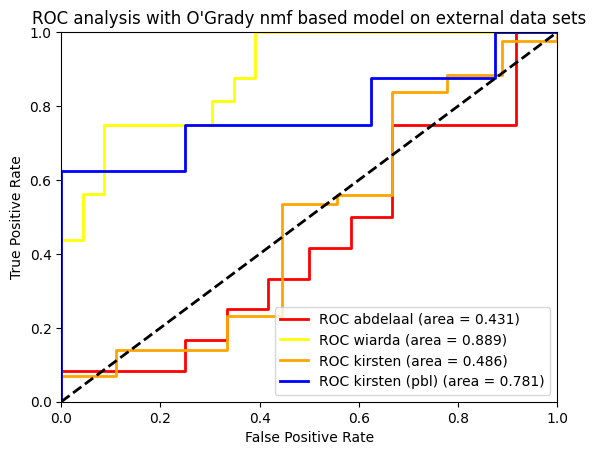

In [85]:
y_score_nmf = ogrady_nmf.predict_proba(ogrady_abdelaal)
ogrady_abdelaal_fprG_nmf, ogrady_abdelaal_tprG_nmf, ogrady_abdelaal_t_nmf = roc_curve(abdelaal_labels_simple, y_score_nmf[:,1])
ogrady_abdelaal_roc_aucG_nmf = auc(ogrady_abdelaal_fprG_nmf, ogrady_abdelaal_tprG_nmf)


y_score_nmf = ogrady_nmf.predict_proba(ogrady_wiarda)
ogrady_wiarda_fprG_nmf, ogrady_wiarda_tprG_nmf, ogrady_wiarda_t_nmf = roc_curve(wiarda_labels_simple, y_score_nmf[:,1])
ogrady_wiarda_roc_aucG_nmf = auc(ogrady_wiarda_fprG_nmf, ogrady_wiarda_tprG_nmf)


y_score_nmf = ogrady_nmf.predict_proba(ogrady_kirsten)
ogrady_kirsten_fprG_nmf, ogrady_kirsten_tprG_nmf, ogrady_kirsten_t_nmf = roc_curve(kirsten_labels_simple, y_score_nmf[:,1])
ogrady_kirsten_roc_aucG_nmf = auc(ogrady_kirsten_fprG_nmf, ogrady_kirsten_tprG_nmf)


y_score_nmf = ogrady_nmf.predict_proba(ogrady_kirsten_pbl)
ogrady_kirsten_pbl_fprG_nmf, ogrady_kirsten_pbl_tprG_nmf, ogrady_kirsten_pbl_t_nmf = roc_curve(kirsten_pbl_labels_simple, y_score_nmf[:,1])
ogrady_kirsten_pbl_roc_aucG_nmf = auc(ogrady_kirsten_pbl_fprG_nmf, ogrady_kirsten_pbl_tprG_nmf)


%matplotlib inline
plt.figure()
lw = 2
plt.plot(ogrady_abdelaal_fprG_nmf, ogrady_abdelaal_tprG_nmf, color='red',
         lw=lw, label='ROC abdelaal (area = %0.3f)' % ogrady_abdelaal_roc_aucG_nmf)
plt.plot(ogrady_wiarda_fprG_nmf, ogrady_wiarda_tprG_nmf, color='yellow',
         lw=lw, label='ROC wiarda (area = %0.3f)' % ogrady_wiarda_roc_aucG_nmf)
plt.plot(ogrady_kirsten_fprG_nmf, ogrady_kirsten_tprG_nmf, color='orange',
         lw=lw, label='ROC kirsten (area = %0.3f)' % ogrady_kirsten_roc_aucG_nmf)
plt.plot(ogrady_kirsten_pbl_fprG_nmf, ogrady_kirsten_pbl_tprG_nmf, color='blue',
         lw=lw, label='ROC kirsten (pbl) (area = %0.3f)' % ogrady_kirsten_pbl_roc_aucG_nmf)

plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC analysis with O'Grady nmf based model on external data sets")
plt.legend(loc="lower right")
plt.show()




Abdelaal


In [86]:

with open("/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Abdelaal_Logistic_regression_l10.2_search.pkl", 'rb') as f:
    abdelaal_gene = pickle.load(f)



with open("/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Abdelaal_Logistic_regression_PCA_search.pkl", 'rb') as f:
    abdelaal_pca = pickle.load(f)




with open("/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Abdelaal_Logistic_regression_ICA_search.pkl", 'rb') as f:
    abdelaal_ica = pickle.load(f)



with open("/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Abdelaal_Logistic_regression_NMF_search.pkl", 'rb') as f:
    abdelaal_nmf = pickle.load(f)
    
# Note the raw will be for if individuals wish to put in a MAD filter on the data
abdelaal_train_data = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_individual/abdelaal_vst_normalised_data.txt", sep = "\t").T

# The data and labels
abdelaal_ogrady = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_combined/ogradytest_abdelaal_vst_normalised_data.txt", sep = "\t")
abdelaal_wiarda = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_combined/wiarda_abdelaal_vst_normalised_data.txt", sep = "\t")
abdelaal_kirsten = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_combined/kirsten_abdelaal_vst_normalised_data.txt", sep = "\t")
abdelaal_kirsten_pbl = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_combined/kirsten_pbl_abdelaal_vst_normalised_data.txt", sep = "\t")
abdelaal_ogrady.set_index(abdelaal_train_data.T.index, inplace = True) 
abdelaal_wiarda.set_index(abdelaal_train_data.T.index,inplace = True) 
abdelaal_kirsten.set_index(abdelaal_train_data.T.index,inplace = True) 
abdelaal_kirsten_pbl.set_index(abdelaal_train_data.T.index,inplace = True)



# Calcualte variances for VST normalised genes
variances = abdelaal_train_data.var(axis=0)
# take top 20% and filter
threshold = variances.quantile(.80) 
genes = variances > threshold
genes= genes.loc[genes==True].index
abdelaal_train_data = abdelaal_train_data.filter(items = genes, axis=1)


abdelaal_ogrady = abdelaal_ogrady.T.filter(items = genes, axis=1)
abdelaal_wiarda = abdelaal_wiarda.T.filter(items = genes, axis=1)

abdelaal_kirsten = abdelaal_kirsten.T.filter(items = genes, axis=1)

abdelaal_kirsten_pbl = abdelaal_kirsten_pbl.T.filter(items = genes, axis=1)





# Gene
y_score_gene = abdelaal_gene.predict_proba(abdelaal_ogrady)
abdelaal_ogrady_fprG_gene, abdelaal_ogrady_tprG_gene, abdelaal_ogrady_t_gene = roc_curve(ogradytest_labels_simple, y_score_gene[:,1])
abdelaal_ogrady_roc_aucG_gene = auc(abdelaal_ogrady_fprG_gene, abdelaal_ogrady_tprG_gene)
print(abdelaal_ogrady_roc_aucG_gene)


y_score_gene = abdelaal_gene.predict_proba(abdelaal_wiarda)
abdelaal_wiarda_fprG_gene, abdelaal_wiarda_tprG_gene, abdelaal_wiarda_t_gene = roc_curve(wiarda_labels_simple, y_score_gene[:,1])
abdelaal_wiarda_roc_aucG_gene = auc(abdelaal_wiarda_fprG_gene, abdelaal_wiarda_tprG_gene)


y_score_gene = abdelaal_gene.predict_proba(abdelaal_kirsten)
abdelaal_kirsten_fprG_gene, abdelaal_kirsten_tprG_gene, abdelaal_kirsten_t_gene = roc_curve(kirsten_labels_simple, y_score_gene[:,1])
abdelaal_kirsten_roc_aucG_gene = auc(abdelaal_kirsten_fprG_gene, abdelaal_kirsten_tprG_gene)


y_score_gene = abdelaal_gene.predict_proba(abdelaal_kirsten_pbl)
abdelaal_kirsten_pbl_fprG_gene, abdelaal_kirsten_pbl_tprG_gene, abdelaal_kirsten_pbl_t_gene = roc_curve(kirsten_pbl_labels_simple, y_score_gene[:,1])
abdelaal_kirsten_pbl_roc_aucG_gene = auc(abdelaal_kirsten_pbl_fprG_gene, abdelaal_kirsten_pbl_tprG_gene)


0.44753086419753085


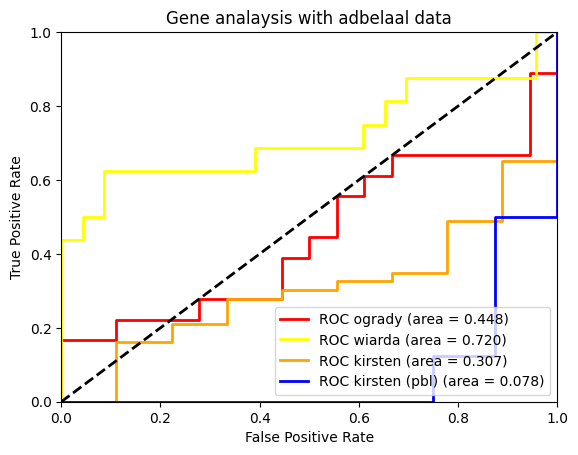

In [87]:
%matplotlib inline
plt.figure()
lw = 2
plt.plot(abdelaal_ogrady_fprG_gene, abdelaal_ogrady_tprG_gene, color='red',
         lw=lw, label='ROC ogrady (area = %0.3f)' % abdelaal_ogrady_roc_aucG_gene)
plt.plot(abdelaal_wiarda_fprG_gene, abdelaal_wiarda_tprG_gene, color='yellow',
         lw=lw, label='ROC wiarda (area = %0.3f)' % abdelaal_wiarda_roc_aucG_gene)
plt.plot(abdelaal_kirsten_fprG_gene, abdelaal_kirsten_tprG_gene, color='orange',
         lw=lw, label='ROC kirsten (area = %0.3f)' % abdelaal_kirsten_roc_aucG_gene)
plt.plot(abdelaal_kirsten_pbl_fprG_gene, abdelaal_kirsten_pbl_tprG_gene, color='blue',
         lw=lw, label='ROC kirsten (pbl) (area = %0.3f)' % abdelaal_kirsten_pbl_roc_aucG_gene)

plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Gene analaysis with adbelaal data")
plt.legend(loc="lower right")
plt.show()

In [88]:
y_score_pca = abdelaal_pca.predict_proba(abdelaal_ogrady)
abdelaal_ogrady_fprG_pca, abdelaal_ogrady_tprG_pca, abdelaal_ogrady_t_pca = roc_curve(ogradytest_labels_simple, y_score_pca[:,1])
abdelaal_ogrady_roc_aucG_pca = auc(abdelaal_ogrady_fprG_pca, abdelaal_ogrady_tprG_pca)


y_score_pca = abdelaal_pca.predict_proba(abdelaal_wiarda)
abdelaal_wiarda_fprG_pca, abdelaal_wiarda_tprG_pca, abdelaal_wiarda_t_pca = roc_curve(wiarda_labels_simple, y_score_pca[:,1])
abdelaal_wiarda_roc_aucG_pca = auc(abdelaal_wiarda_fprG_pca, abdelaal_wiarda_tprG_pca)


y_score_pca = abdelaal_pca.predict_proba(abdelaal_kirsten)
abdelaal_kirsten_fprG_pca, abdelaal_kirsten_tprG_pca, abdelaal_kirsten_t_pca = roc_curve(kirsten_labels_simple, y_score_pca[:,1])
abdelaal_kirsten_roc_aucG_pca = auc(abdelaal_kirsten_fprG_pca, abdelaal_kirsten_tprG_pca)


y_score_pca = abdelaal_pca.predict_proba(abdelaal_kirsten_pbl)
abdelaal_kirsten_pbl_fprG_pca, abdelaal_kirsten_pbl_tprG_pca, abdelaal_kirsten_pbl_t_pca = roc_curve(kirsten_pbl_labels_simple, y_score_pca[:,1])
abdelaal_kirsten_pbl_roc_aucG_pca = auc(abdelaal_kirsten_pbl_fprG_pca, abdelaal_kirsten_pbl_tprG_pca)

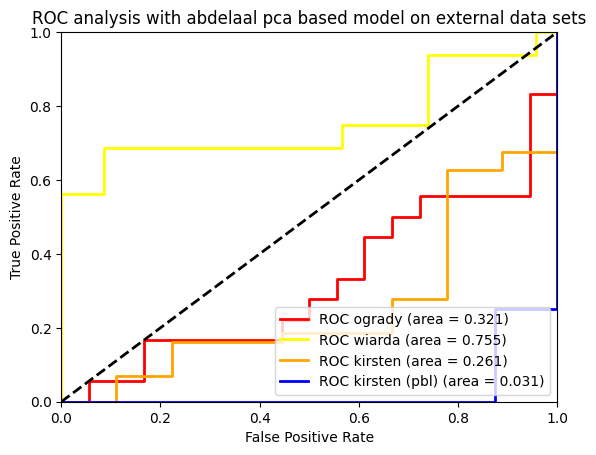

In [89]:
%matplotlib inline
plt.figure()
lw = 2
plt.plot(abdelaal_ogrady_fprG_pca, abdelaal_ogrady_tprG_pca, color='red',
         lw=lw, label='ROC ogrady (area = %0.3f)' % abdelaal_ogrady_roc_aucG_pca)
plt.plot(abdelaal_wiarda_fprG_pca, abdelaal_wiarda_tprG_pca, color='yellow',
         lw=lw, label='ROC wiarda (area = %0.3f)' % abdelaal_wiarda_roc_aucG_pca)
plt.plot(abdelaal_kirsten_fprG_pca, abdelaal_kirsten_tprG_pca, color='orange',
         lw=lw, label='ROC kirsten (area = %0.3f)' % abdelaal_kirsten_roc_aucG_pca)
plt.plot(abdelaal_kirsten_pbl_fprG_pca, abdelaal_kirsten_pbl_tprG_pca, color='blue',
         lw=lw, label='ROC kirsten (pbl) (area = %0.3f)' % abdelaal_kirsten_pbl_roc_aucG_pca)

plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC analysis with abdelaal pca based model on external data sets")
plt.legend(loc="lower right")
plt.show()

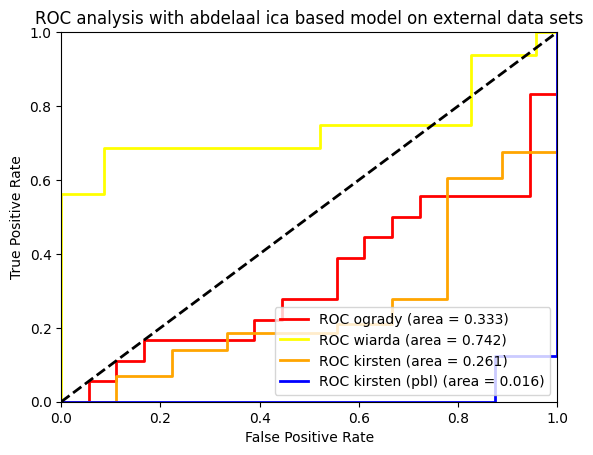

In [90]:
# ICA
y_score_ica = abdelaal_ica.predict_proba(abdelaal_ogrady)
abdelaal_ogrady_fprG_ica, abdelaal_ogrady_tprG_ica, abdelaal_ogrady_t_ica = roc_curve(ogradytest_labels_simple, y_score_ica[:,1])
abdelaal_ogrady_roc_aucG_ica = auc(abdelaal_ogrady_fprG_ica, abdelaal_ogrady_tprG_ica)


y_score_ica = abdelaal_ica.predict_proba(abdelaal_wiarda)
abdelaal_wiarda_fprG_ica, abdelaal_wiarda_tprG_ica, abdelaal_wiarda_t_ica = roc_curve(wiarda_labels_simple, y_score_ica[:,1])
abdelaal_wiarda_roc_aucG_ica = auc(abdelaal_wiarda_fprG_ica, abdelaal_wiarda_tprG_ica)


y_score_ica = abdelaal_ica.predict_proba(abdelaal_kirsten)
abdelaal_kirsten_fprG_ica, abdelaal_kirsten_tprG_ica, abdelaal_kirsten_t_ica = roc_curve(kirsten_labels_simple, y_score_ica[:,1])
abdelaal_kirsten_roc_aucG_ica = auc(abdelaal_kirsten_fprG_ica, abdelaal_kirsten_tprG_ica)


y_score_ica = abdelaal_ica.predict_proba(abdelaal_kirsten_pbl)
abdelaal_kirsten_pbl_fprG_ica, abdelaal_kirsten_pbl_tprG_ica, abdelaal_kirsten_pbl_t_ica = roc_curve(kirsten_pbl_labels_simple, y_score_ica[:,1])
abdelaal_kirsten_pbl_roc_aucG_ica = auc(abdelaal_kirsten_pbl_fprG_ica, abdelaal_kirsten_pbl_tprG_ica)
%matplotlib inline
plt.figure()
lw = 2
plt.plot(abdelaal_ogrady_fprG_ica, abdelaal_ogrady_tprG_ica, color='red',
         lw=lw, label='ROC ogrady (area = %0.3f)' % abdelaal_ogrady_roc_aucG_ica)
plt.plot(abdelaal_wiarda_fprG_ica, abdelaal_wiarda_tprG_ica, color='yellow',
         lw=lw, label='ROC wiarda (area = %0.3f)' % abdelaal_wiarda_roc_aucG_ica)
plt.plot(abdelaal_kirsten_fprG_ica, abdelaal_kirsten_tprG_ica, color='orange',
         lw=lw, label='ROC kirsten (area = %0.3f)' % abdelaal_kirsten_roc_aucG_ica)
plt.plot(abdelaal_kirsten_pbl_fprG_ica, abdelaal_kirsten_pbl_tprG_ica, color='blue',
         lw=lw, label='ROC kirsten (pbl) (area = %0.3f)' % abdelaal_kirsten_pbl_roc_aucG_ica)

plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC analysis with abdelaal ica based model on external data sets")
plt.legend(loc="lower right")
plt.show()

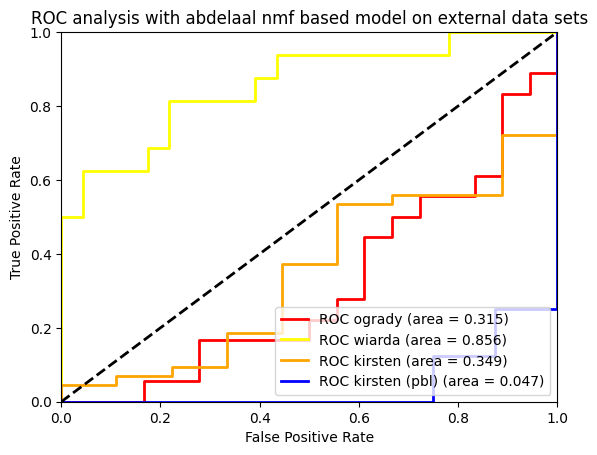

In [91]:
# NMF
# nmf
y_score_nmf = abdelaal_nmf.predict_proba(abdelaal_ogrady)
abdelaal_ogrady_fprG_nmf, abdelaal_ogrady_tprG_nmf, abdelaal_ogrady_t_nmf = roc_curve(ogradytest_labels_simple, y_score_nmf[:,1])
abdelaal_ogrady_roc_aucG_nmf = auc(abdelaal_ogrady_fprG_nmf, abdelaal_ogrady_tprG_nmf)


y_score_nmf = abdelaal_nmf.predict_proba(abdelaal_wiarda)
abdelaal_wiarda_fprG_nmf, abdelaal_wiarda_tprG_nmf, abdelaal_wiarda_t_nmf = roc_curve(wiarda_labels_simple, y_score_nmf[:,1])
abdelaal_wiarda_roc_aucG_nmf = auc(abdelaal_wiarda_fprG_nmf, abdelaal_wiarda_tprG_nmf)


y_score_nmf = abdelaal_nmf.predict_proba(abdelaal_kirsten)
abdelaal_kirsten_fprG_nmf, abdelaal_kirsten_tprG_nmf, abdelaal_kirsten_t_nmf = roc_curve(kirsten_labels_simple, y_score_nmf[:,1])
abdelaal_kirsten_roc_aucG_nmf = auc(abdelaal_kirsten_fprG_nmf, abdelaal_kirsten_tprG_nmf)


y_score_nmf = abdelaal_nmf.predict_proba(abdelaal_kirsten_pbl)
abdelaal_kirsten_pbl_fprG_nmf, abdelaal_kirsten_pbl_tprG_nmf, abdelaal_kirsten_pbl_t_nmf = roc_curve(kirsten_pbl_labels_simple, y_score_nmf[:,1])
abdelaal_kirsten_pbl_roc_aucG_nmf = auc(abdelaal_kirsten_pbl_fprG_nmf, abdelaal_kirsten_pbl_tprG_nmf)
%matplotlib inline
plt.figure()
lw = 2
plt.plot(abdelaal_ogrady_fprG_nmf, abdelaal_ogrady_tprG_nmf, color='red',
         lw=lw, label='ROC ogrady (area = %0.3f)' % abdelaal_ogrady_roc_aucG_nmf)
plt.plot(abdelaal_wiarda_fprG_nmf, abdelaal_wiarda_tprG_nmf, color='yellow',
         lw=lw, label='ROC wiarda (area = %0.3f)' % abdelaal_wiarda_roc_aucG_nmf)
plt.plot(abdelaal_kirsten_fprG_nmf, abdelaal_kirsten_tprG_nmf, color='orange',
         lw=lw, label='ROC kirsten (area = %0.3f)' % abdelaal_kirsten_roc_aucG_nmf)
plt.plot(abdelaal_kirsten_pbl_fprG_nmf, abdelaal_kirsten_pbl_tprG_nmf, color='blue',
         lw=lw, label='ROC kirsten (pbl) (area = %0.3f)' % abdelaal_kirsten_pbl_roc_aucG_nmf)

plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC analysis with abdelaal nmf based model on external data sets")
plt.legend(loc="lower right")
plt.show()

# Wiarda

In [97]:

with open("/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Wiarda_Logistic_regression_l10.1_search.pkl", 'rb') as f:
    wiarda_gene = pickle.load(f)



with open("/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Wiarda_Logistic_regression_PCA_search.pkl", 'rb') as f:
    wiarda_pca = pickle.load(f)




with open("/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Wiarda_Logistic_regression_ICA_search.pkl", 'rb') as f:
    wiarda_ica = pickle.load(f)



with open("/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Wiarda_Logistic_regression_NMF_search.pkl", 'rb') as f:
    wiarda_nmf = pickle.load(f)
    
# Note the raw will be for if individuals wish to put in a MAD filter on the data
wiarda_train_data = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_individual/wiarda_vst_normalised_data.txt", sep = "\t").T

# The data and labels
wiarda_ogrady = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_combined/ogradytest_wiarda_vst_normalised_data.txt", sep = "\t")
wiarda_abdelaal = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_combined/abdelaal_wiarda_vst_normalised_data.txt", sep = "\t")
wiarda_kirsten = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_combined/kirsten_wiarda_vst_normalised_data.txt", sep = "\t")
wiarda_kirsten_pbl = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_combined/kirsten_pbl_wiarda_vst_normalised_data.txt", sep = "\t")
wiarda_ogrady.set_index(wiarda_train_data.T.index, inplace = True) 
wiarda_abdelaal.set_index(wiarda_train_data.T.index,inplace = True) 
wiarda_kirsten.set_index(wiarda_train_data.T.index,inplace = True) 
wiarda_kirsten_pbl.set_index(wiarda_train_data.T.index,inplace = True)



# Calcualte variances for VST normalised genes
variances = wiarda_train_data.var(axis=0)
# take top 20% and filter
threshold = variances.quantile(.80) 
genes = variances > threshold
genes= genes.loc[genes==True].index
wiarda_train_data = wiarda_train_data.filter(items = genes, axis=1)


wiarda_ogrady = wiarda_ogrady.T.filter(items = genes, axis=1)
wiarda_abdelaal = wiarda_abdelaal.T.filter(items = genes, axis=1)

wiarda_kirsten = wiarda_kirsten.T.filter(items = genes, axis=1)

wiarda_kirsten_pbl = wiarda_kirsten_pbl.T.filter(items = genes, axis=1)

# Gene

In [98]:
y_score_gene = wiarda_gene.predict_proba(wiarda_ogrady)
wiarda_ogrady_fprG_gene, wiarda_ogrady_tprG_gene, wiarda_ogrady_t_gene = roc_curve(ogradytest_labels_simple, y_score_gene[:,1])
wiarda_ogrady_roc_aucG_gene = auc(wiarda_ogrady_fprG_gene, wiarda_ogrady_tprG_gene)
print(wiarda_ogrady_roc_aucG_gene)


y_score_gene = wiarda_gene.predict_proba(wiarda_abdelaal)
wiarda_abdelaal_fprG_gene, wiarda_abdelaal_tprG_gene, wiarda_abdelaal_t_gene = roc_curve(abdelaal_labels_simple, y_score_gene[:,1])
wiarda_abdelaal_roc_aucG_gene = auc(wiarda_abdelaal_fprG_gene, wiarda_abdelaal_tprG_gene)


y_score_gene = wiarda_gene.predict_proba(wiarda_kirsten)
wiarda_kirsten_fprG_gene, wiarda_kirsten_tprG_gene, wiarda_kirsten_t_gene = roc_curve(kirsten_labels_simple, y_score_gene[:,1])
wiarda_kirsten_roc_aucG_gene = auc(wiarda_kirsten_fprG_gene, wiarda_kirsten_tprG_gene)


y_score_gene = wiarda_gene.predict_proba(wiarda_kirsten_pbl)
wiarda_kirsten_pbl_fprG_gene, wiarda_kirsten_pbl_tprG_gene, wiarda_kirsten_pbl_t_gene = roc_curve(kirsten_pbl_labels_simple, y_score_gene[:,1])
wiarda_kirsten_pbl_roc_aucG_gene = auc(wiarda_kirsten_pbl_fprG_gene, wiarda_kirsten_pbl_tprG_gene)

0.5401234567901234


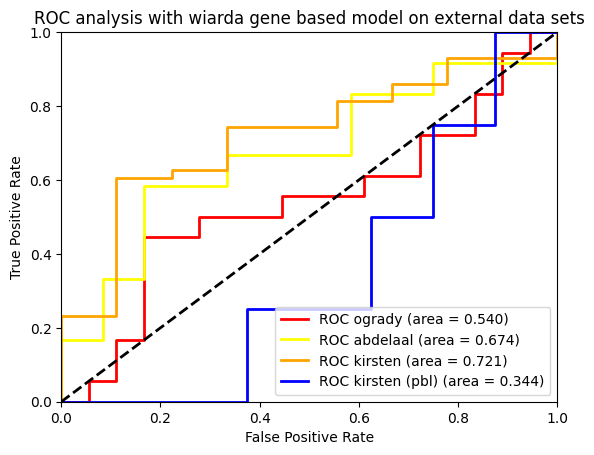

In [100]:
%matplotlib inline
plt.figure()
lw = 2
plt.plot(wiarda_ogrady_fprG_gene, wiarda_ogrady_tprG_gene, color='red',
         lw=lw, label='ROC ogrady (area = %0.3f)' % wiarda_ogrady_roc_aucG_gene)
plt.plot(wiarda_abdelaal_fprG_gene, wiarda_abdelaal_tprG_gene, color='yellow',
         lw=lw, label='ROC abdelaal (area = %0.3f)' % wiarda_abdelaal_roc_aucG_gene)
plt.plot(wiarda_kirsten_fprG_gene, wiarda_kirsten_tprG_gene, color='orange',
         lw=lw, label='ROC kirsten (area = %0.3f)' % wiarda_kirsten_roc_aucG_gene)
plt.plot(wiarda_kirsten_pbl_fprG_gene, wiarda_kirsten_pbl_tprG_gene, color='blue',
         lw=lw, label='ROC kirsten (pbl) (area = %0.3f)' % wiarda_kirsten_pbl_roc_aucG_gene)
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC analysis with wiarda gene based model on external data sets")
plt.legend(loc="lower right")
plt.show()